In [ ]:
import jax.numpy as np
from jax import grad
from matplotlib import pyplot as plt
import jax

%matplotlib inline

In [ ]:
f = lambda x: np.exp(x)
g = lambda x: np.square(x)

In [ ]:
print(grad(f)(1.))

2.7182817


In [ ]:
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
# import flax # neural network library
# from flax import linen as nn
from jax.experimental import stax
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # neural network layers


In [ ]:
 # Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1)
)
in_shape = (-1, 1,)
out_shape, net_params = net_init(jax.random.PRNGKey(seed=42), in_shape)

In [ ]:
 def mse_loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

In [ ]:
xrange_inputs = np.linspace(-5,5,100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)

In [ ]:
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(mse_loss, net_params))(xrange_inputs, targets)

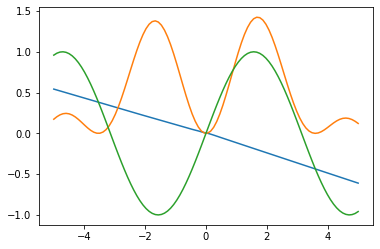

In [ ]:
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')


In [ ]:
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays

In [ ]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(net_params)
# Define a compiled update step
@jit
def step(i, opt_state, x1, y1):
    p = get_params(opt_state)
    g = grad(mse_loss)(p, x1, y1)
    return opt_update(i, g, opt_state)

for i in range(100):
    opt_state = step(i, opt_state, xrange_inputs, targets)
net_params = get_params(opt_state)

In [ ]:
g = lambda x, y : np.square(x) + y
x0 = 2.
y0 = 1.
print('grad(g)(x0) = {}'.format(grad(g)(x0, y0))) # 2x = 4
print('x0 - grad(g)(x0) = {}'.format(x0 - grad(g)(x0, y0))) # x - 2x = -2
def maml_objective(x, y):
    return g(x - grad(g)(x, y), y)
print('maml_objective(x,y)={}'.format(maml_objective(x0, y0))) # x**2 + 1 = 5
print('x0 - maml_objective(x,y) = {}'.format(x0 - grad(maml_objective)(x0, y0))) 

grad(g)(x0) = 4.0
x0 - grad(g)(x0) = -2.0
maml_objective(x,y)=5.0
x0 - maml_objective(x,y) = -2.0


In [ ]:
 def inner_update(p, x1, y1, alpha=.1):
    grads = grad(mse_loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return mse_loss(p2, x2, y2)

In [ ]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)  # this LR seems to be better than 1e-2 and 1e-4
out_shape, net_params = net_init(jax.random.PRNGKey(seed=42), in_shape)
opt_state = opt_init(net_params)

In [ ]:
@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(maml_loss)(p, x1, y1, x2, y2)
    l = maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l
K=20

In [ ]:
np_maml_loss = []

# Adam optimization
for i in range(20000):
    # define the task
    A = onp.random.uniform(low=0.1, high=.5)
    phase = onp.random.uniform(low=0., high=np.pi)
    # meta-training inner split (K examples)
    x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
    y1 = A * onp.sin(x1 + phase)
    # meta-training outer split (1 example). Like cross-validating with respect to one example.
    x2 = onp.random.uniform(low=-5., high=5.)
    y2 = A * onp.sin(x2 + phase)
    opt_state, l = step(i, opt_state, x1, y1, x2, y2)
    np_maml_loss.append(l)
    if i % 1000 == 0:
        print(i)
net_params = get_params(opt_state)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


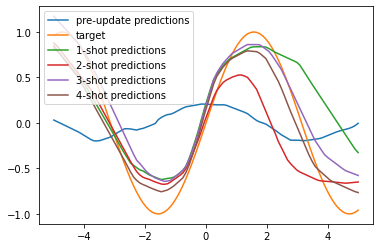

In [ ]:
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1,5):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()